### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [2]:
def gini_impurity(y):
    classes = np.unique(y)
    count_classes = classes.shape[0]
    shape = y.shape[0]
    gini = 1
    for i in range(count_classes):
        p_i = (np.count_nonzero(y == classes[i]))/shape
        gini -= p_i**2
    return gini
def entropy(y):
    classes = np.unique(y)
    count_classes = classes.shape[0]
    shape = y.shape[0]
    entropy_score = 0
    for i in range(count_classes):
        p_i = (np.count_nonzero(y == classes[i]))/shape
        entropy_score -= p_i*np.log2(p_i)
    return entropy_score
def classification_error(y):
    classes = np.unique(y)
    count_classes = classes.shape[0]
    shape = y.shape[0]
    x = []
    for i in range(count_classes):
        p_i = np.count_nonzero(y == classes[i])/shape
        x.append(p_i)
    return (1 - np.max(x))

In [42]:

class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 1
    LEAF_TYPE = 0

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = True
        self.feature_list = np.array([])
        if criterion == 'gini':
            self.criterion = gini_impurity
        elif criterion == 'entropy':
            self.criterion = entropy
        else:
            self.criterion = classification_error
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = np.zeros((2**(max_depth + 1),3))

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """        
        left_mask = x[:, feature_id] > threshold
        right_mask = np.logical_not(left_mask)       
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        columns = x.shape[1] # Count of different features
        min_criterion_score = 10000
        best_feature_id = 0
        borderline = 0
        last_shape = 0
        for each in range(columns):
            values = np.unique(x[:,each]) #For each column
            for value in values: # for each border
                y_predict = y[x[:,each] < value] # ATENTION, here I used x!
                if y_predict.shape[0] < self.min_samples_split:
                    continue
                criterion_score = self.criterion(y_predict) # calculate criterion!                
                #print("Score "+str(criterion_score) + "\n")
                #print("Shape "+str(y_predict.shape),"last shape ",last_shape)
                if criterion_score < min_criterion_score:
                    min_criterion_score = criterion_score
                    best_feature_id = each
                    borderline = value # save borderline
                    last_shape = y_predict.shape[0]
                elif criterion_score == min_criterion_score:
                    if last_shape < y_predict.shape[0]:
                        best_feature_id = each
                        borderline = value
                        last_shape = y_predict.shape[0]
        if self.feature_importances_:
            self.update_importances(best_feature_id,min_criterion_score)
        return (best_feature_id,borderline) # return results
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        """
        if depth == self.max_depth :
            classes = np.unique(y)
            count_classes = classes.shape[0]
            shape = y.shape[0]
            probabilities = []
            for i in range(count_classes):
                p_i = np.count_nonzero(y == classes[i])/shape
                probabilities.append(p_i)
            pred_cls_id = np.argmax(probabilities)
            node = [self.LEAF_TYPE,classes[pred_cls_id],probabilities[pred_cls_id]]
            self.tree[node_id][:] = node
        else:
            feature_id, border = self.__find_threshold(x,y)
            node = [self.NON_LEAF_TYPE,feature_id,border]
            feature_id, border = self.__find_threshold(x,y)
            x_left, x_right, y_left, y_right = self.__div_samples(x,y,feature_id,border)
            self.tree[node_id][:]  = node
            if x_left.shape[0] > self.min_samples_split:                              
                self.__fit_node(x_left,y_left,2*node_id+1,depth+1)  #form left
            if x_right.shape[0] > self.min_samples_split:
                self.__fit_node(x_right,y_right,2*node_id+2,depth+1)  #form right
            
        
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """       
        if self.feature_importances_:
            self.feature_list = np.zeros(x.shape[1])
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)         
    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if int(node[0]) == self.__class__.NON_LEAF_TYPE:
            feature_id = int(node[1])
            threshold = node[2]            
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return int(node[1])
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self,column_names,count):
        """
        Возвращает важность признаков
        """
        numbers = np.argpartition(-self.feature_list,count)[:count]
        norm = (self.feature_list).sum()
        result = {name : importance/norm for name,importance in zip(column_names[numbers],self.feature_list[numbers])}
        return result
    def update_importances(self,feature,value):
        self.feature_list[feature] += (1 - value)
                

In [8]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [9]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)
clf.fit(X_train,y_train)
my_clf.fit(X_train,y_train)

In [10]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test),accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
# My score is the better)

0.7777777777777778 0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 3 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 597 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет засчитано. 


In [14]:
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')
df = df.iloc[:, :97]
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df.drop_duplicates(subset=['iid']).gender.value_counts()
df = df.drop(['condtn'], axis=1)
df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)
le = LabelEncoder()
df.loc[:, 'field'] = le.fit_transform(np.array(df.loc[:, 'field'].fillna("None")).reshape(-1,1))
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df['mn_sat'] = df['mn_sat'].fillna(df['mn_sat'].mean())
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df = df.drop('tuition', axis = 1)
df['race'] = df.race.fillna(7)
df.imprelig = df.imprelig.fillna(df.imprelig.mean())
df = df.drop(['from', 'zipcode'], axis=1)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(df.loc[:, 'income'].median())
df = df.dropna(subset=['date'])
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
le = LabelEncoder()
df.loc[:, 'career'] = le.fit_transform(np.array(df.loc[:, 'career'].fillna("None")).reshape(-1,1))
interests = ['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
for interest in interests:
    df[interest] = df[interest].fillna(-1)
df.exphappy = df.exphappy.fillna(df.exphappy.mean())
df.expnum = df.exphappy.fillna(df.expnum.mean())
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['wave'], axis=1)
le = LabelEncoder()
df.undergra = le.fit_transform(df.undergra.fillna("None"))
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'
man = df_male[:]
woman = df_female[:]
woman = woman.rename(columns = {'iid_f':'pid'})
pairs = man.merge(woman, on = 'pid')
pairs = pairs.drop('partner',axis = 1)
pairs = pairs.drop('partner_f',axis = 1)
pairs = pairs.drop('pid',axis = 1)
pairs = pairs.drop('iid',axis = 1)
pairs = pairs.drop('pid_f',axis = 1)
y = pairs.match
y = pd.DataFrame(y)
x = pairs.drop('match',axis = 1)

E:\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y) 

In [23]:
mdt = MyDecisionTreeClassifier(max_depth=23,min_samples_split=2)

In [24]:
mdt.fit(np.array(x_train),np.array(y_train))

In [25]:
y_pred_ = mdt.predict(np.array(x_test))

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_pred_,y_test)

0.6010789324247586

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [27]:
from tqdm import tqdm_notebook 

In [28]:
scores = []
param = []
for i in tqdm_notebook(range(1,5)):
    m = MyDecisionTreeClassifier(max_depth=20, min_samples_split = i )
    m.fit(np.array(x_train),np.array(y_train))
    y_pred = m.predict(np.array(x_test))
    try:
        score = roc_auc_score(y_pred,y_test)
        scores.append(score)
        param.append(i)
    except :
        scores.append(0.5)
        param.append(i)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


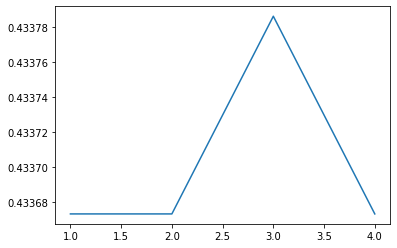

In [29]:
plt.plot(param, scores)

In [35]:
scores = []
param = []
for i in tqdm_notebook(range(10,30,4)):
    m = MyDecisionTreeClassifier(max_depth = i, min_samples_split = 2 )
    m.fit(np.array(x_train),np.array(y_train))
    y_pred = m.predict(np.array(x_test))
    try:
        score = roc_auc_score(y_pred,y_test)
        scores.append(score)
        param.append(i)
    except :
        scores.append(0.5)
        param.append(i)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


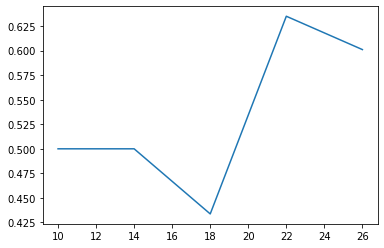

In [37]:
plt.plot(param,scores)

### Наибольшая точность при метрике roc-auc равна 0.635042735042735 и достигается при наибольшей глубине дерева 22

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [43]:
m = MyDecisionTreeClassifier(max_depth=22,min_samples_split=2)
m.fit(np.array(x_train),np.array(y_train))

In [45]:
m.get_feature_importance(x_train.columns,10)

{'gaming_f': 0.04678362573099415,
 'int_corr': 0.23976608187134502,
 'age': 0.05263157894736842,
 'field': 0.07407407407407407,
 'field_f': 0.03898635477582846,
 'undergra': 0.05263157894736842,
 'gaming': 0.06237816764132553,
 'race': 0.06432748538011696,
 'exercise': 0.03898635477582846,
 'concerts_f': 0.037037037037037035}

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

Было затруднительно оптимизировать дерево решений. Возможно, стоило дать более детальные советы )

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



 Задание показалось очень полезным, поскольку дерево решений очень интересный алгоритм. Предложенный способ со словарем был удобен для понимания (однако, видимо, он не очень эффективен :) )
